<a href="https://colab.research.google.com/github/Clement-Okolo/Census-Bureau-Project/blob/main/01_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Income Classification Model: Census Bureau Data Analysis**

## Objective
Build a classifier to predict whether individuals earn **< $50k or > $50k** based on 40 demographic and employment variables from Census Bureau data.

## Business Context
- **Client**: Retail business for targeted marketing
- **Goal**: Identify high and low-income segments for personalized marketing strategies
- **Data**: Weighted census survey data (1994-1995) with 41 variables + weight + label
- **Key Constraint**: Account for stratified sampling weights in analysis

## **STEP 1 - Exploratory Data Analysis**

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, auc, precision_recall_curve, f1_score, accuracy_score
)

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Load Dataset

In [ ]:
# Load column names
with open('/content/drive/MyDrive/Colab Notebooks/JPMorgan/census-bureau.columns', 'r') as f:
    columns = [line.strip() for line in f.readlines()]

print(f"Total columns: {len(columns)}")
print("Column names:", columns)

# Load data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/JPMorgan/census-bureau.data', names=columns)

print(f"\nDataset shape: {df.shape}")

Total columns: 42
Column names: ['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'wage per hour', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'capital gains', 'capital losses', 'dividends from stocks', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'weight', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'num persons worked for employer', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business or self employed', "fill inc questionnaire for veteran's admin", 've

We load the data header from a `.columns` file and then uses these names to load the dataset from a `.data` file into a pandas DataFrame. The dataset contains 199,523 rows and 42 columns.

In [ ]:
print(df.info(verbose=True)) # print a concise summary of the DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199523 non-null  int64  
 1   class of worker                             199523 non-null  object 
 2   detailed industry recode                    199523 non-null  int64  
 3   detailed occupation recode                  199523 non-null  int64  
 4   education                                   199523 non-null  object 
 5   wage per hour                               199523 non-null  int64  
 6   enroll in edu inst last wk                  199523 non-null  object 
 7   marital stat                                199523 non-null  object 
 8   major industry code                         199523 non-null  object 
 9   major occupation code                       199523 non-null  object 
 

We observed that the ***hispanic origin*** variable contains missing (null) values, whereas all other 41 columns have a complete non-null count of 199,523.

In [ ]:
print(f"\nMissing values in 'hispanic origin' variable:\n{df["hispanic origin"].isnull().sum()}")


Missing values in 'hispanic origin' variable:
874


In [ ]:
df.head(10) # print first 5 rows of the dataset

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
5,48,Private,40,10,Some college but no degree,1200,Not in universe,Married-civilian spouse present,Entertainment,Professional specialty,...,Philippines,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,95,- 50000.
6,42,Private,34,3,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Finance insurance and real estate,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
7,28,Private,4,40,High school graduate,0,Not in universe,Never married,Construction,Handlers equip cleaners etc,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,30,95,- 50000.
8,47,Local government,43,26,Some college but no degree,876,Not in universe,Married-civilian spouse present,Education,Adm support including clerical,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.
9,34,Private,4,37,Some college but no degree,0,Not in universe,Married-civilian spouse present,Construction,Machine operators assmblrs & inspctrs,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.


We looked at the first few roles of the dataset and noticed some columns like ***class of worker*** and ***enroll in edu inst last wk*** contain **"Not in universe"** as an entry, which may be a placeholder for missing data even though pandas technically sees them as non-null strings.

> Question 1: Do we have a Data dictionary that define the structure of the dataset and meaning of entries like **"Not in universe"**?



In [ ]:
# Separate the dataset into numerical and categorical for further exploaration
numerical_vars = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_vars = df.select_dtypes(include=['object']).columns.tolist()

print("Numerical Variables:", len(numerical_vars))
print(numerical_vars)
print("\nCategorical Variables:", len(categorical_vars))
print(categorical_vars)

Numerical Variables: 13
['age', 'detailed industry recode', 'detailed occupation recode', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'weight', 'num persons worked for employer', 'own business or self employed', 'veterans benefits', 'weeks worked in year', 'year']

Categorical Variables: 29
['class of worker', 'education', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birt

## Explore Categorical Variables

In [ ]:
# Show value counts for categorical variables
for col in categorical_vars:
  print(df[col].value_counts())

class of worker
Not in universe                   100245
Private                            72028
Self-employed-not incorporated      8445
Local government                    7784
State government                    4227
Self-employed-incorporated          3265
Federal government                  2925
Never worked                         439
Without pay                          165
Name: count, dtype: int64
education
High school graduate                      48407
Children                                  47422
Some college but no degree                27820
Bachelors degree(BA AB BS)                19865
7th and 8th grade                          8007
10th grade                                 7557
11th grade                                 6876
Masters degree(MA MS MEng MEd MSW MBA)     6541
9th grade                                  6230
Associates degree-occup /vocational        5358
Associates degree-academic program         4363
5th or 6th grade                           3277
12t

*   Another placeholder value **"?"** is found in ***state of previous residence***, ***migration code-change in msa***, ***migration code-change in reg***, ***migration prev res in sunbelt***, ***country of birth father***, ***country of birth mother***, and ***country of birth self*** variables.

*   In ***hispanic origin*** variable, **"Do not know"** may serve as another placeholder for respondents who could not or did not identify with a specific sub-group.

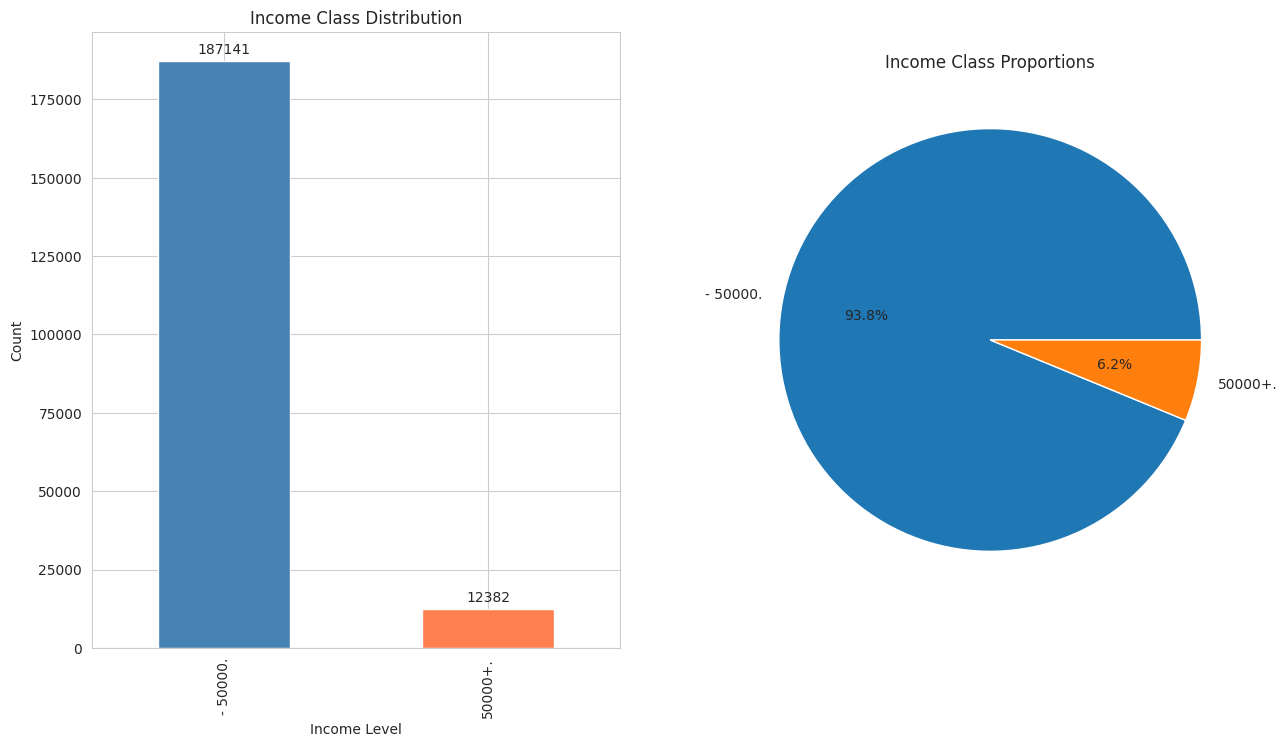

In [ ]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
df['label'].value_counts().plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Income Class Distribution')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Income Level')
axes[0].bar_label(axes[0].containers[0], padding=3)

df['label'].value_counts(normalize=True).plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
axes[1].set_title('Income Class Proportions')
plt.ylabel('')
plt.show()

The dataset exhibits a significant class imbalance, and we need to account for it to ensure the classification model does not develop a bias toward the majority low-income earning class.


## Explore Numerical Variables

In [ ]:
df[numerical_vars].describe() # Show summary statistics for numerical variables

,age,detailed industry recode,detailed occupation recode,wage per hour,capital gains,capital losses,dividends from stocks,weight,num persons worked for employer,own business or self employed,veterans benefits,weeks worked in year,year
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1740.380269,1.956180,0.175438,1.514833,23.174897,94.499672
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,993.768156,2.365126,0.553694,0.851473,24.411488,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,37.870000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1061.615000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1618.310000,1.000000,0.000000,2.000000,8.000000,94.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,2188.610000,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,18656.300000,6.000000,2.000000,2.000000,52.000000,95.000000


 - `age` ranges from 0 to 90 with a mean of ~34, suggesting a diverse demographic.
 - `wage per hour`, `capital gains`, and `dividends from stocks` have a median (50%) of 0, indicating that these variables are highly skewed.
 - `weeks worked in year` shows a mean of ~23 weeks, but the 75th percentile is at 52 weeks, highlighting a significant portion of full-time workers alongside many with zero weeks worked.
 - Extreme maximum values in `capital gains` and `dividends` (99999) suggest potential outliers or capped data values.

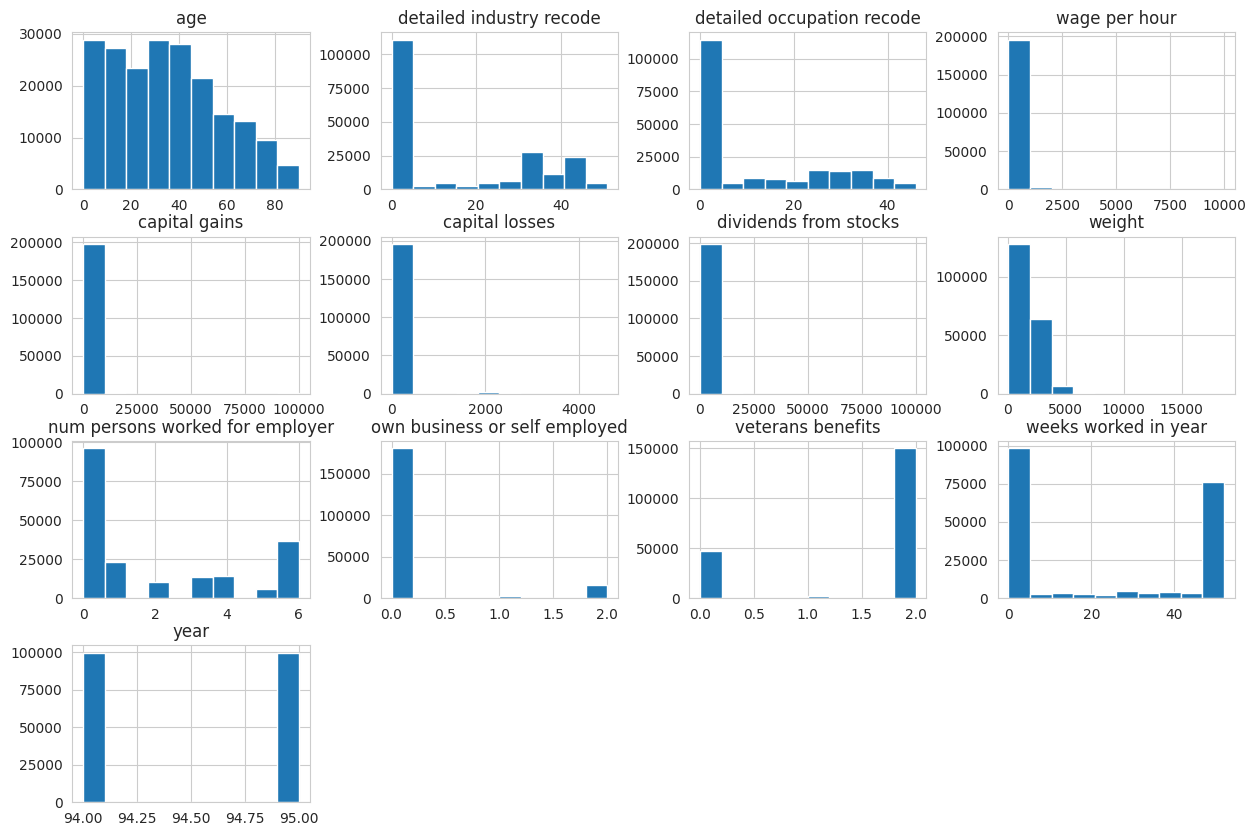

In [ ]:
%matplotlib inline
df[numerical_vars].hist(figsize=(15, 10))
plt.show()

Examining the histograms reveals many numerical variables exhibit right skewness, which creates problems for ML algorithms to detect patterns.

## **STEP 2: Data Preparation/Cleaning**

In [ ]:
df.shape

(199523, 42)

In [ ]:
# Separate features and target
X = df.drop(['label', 'weight'], axis=1)  # Remove label and weight from features
y = df['label'].copy()

weight = df['weight'].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")

Feature matrix shape: (199523, 40)
Target shape: (199523,)


The `weight` variable is removed as a predictive feature because it indicates the relative distribution of people in the general population that each record represents due to stratified sampling. Therefore, it is a survey metadata variable, not a demographic or employment characteristic of the individual necessary for predicting income.

In [ ]:
# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"\nTarget encoding: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

print(f"Feature matrix shape: {X.shape}")
y.shape


Target encoding: {'- 50000.': np.int64(0), '50000+.': np.int64(1)}
Feature matrix shape: (199523, 40)


(199523,)

After label encoding, '- 50000.' is mapped to 0, which represent income less that $5,000;

and '50000+.' is mapped to 1, which represent income more than $5,000





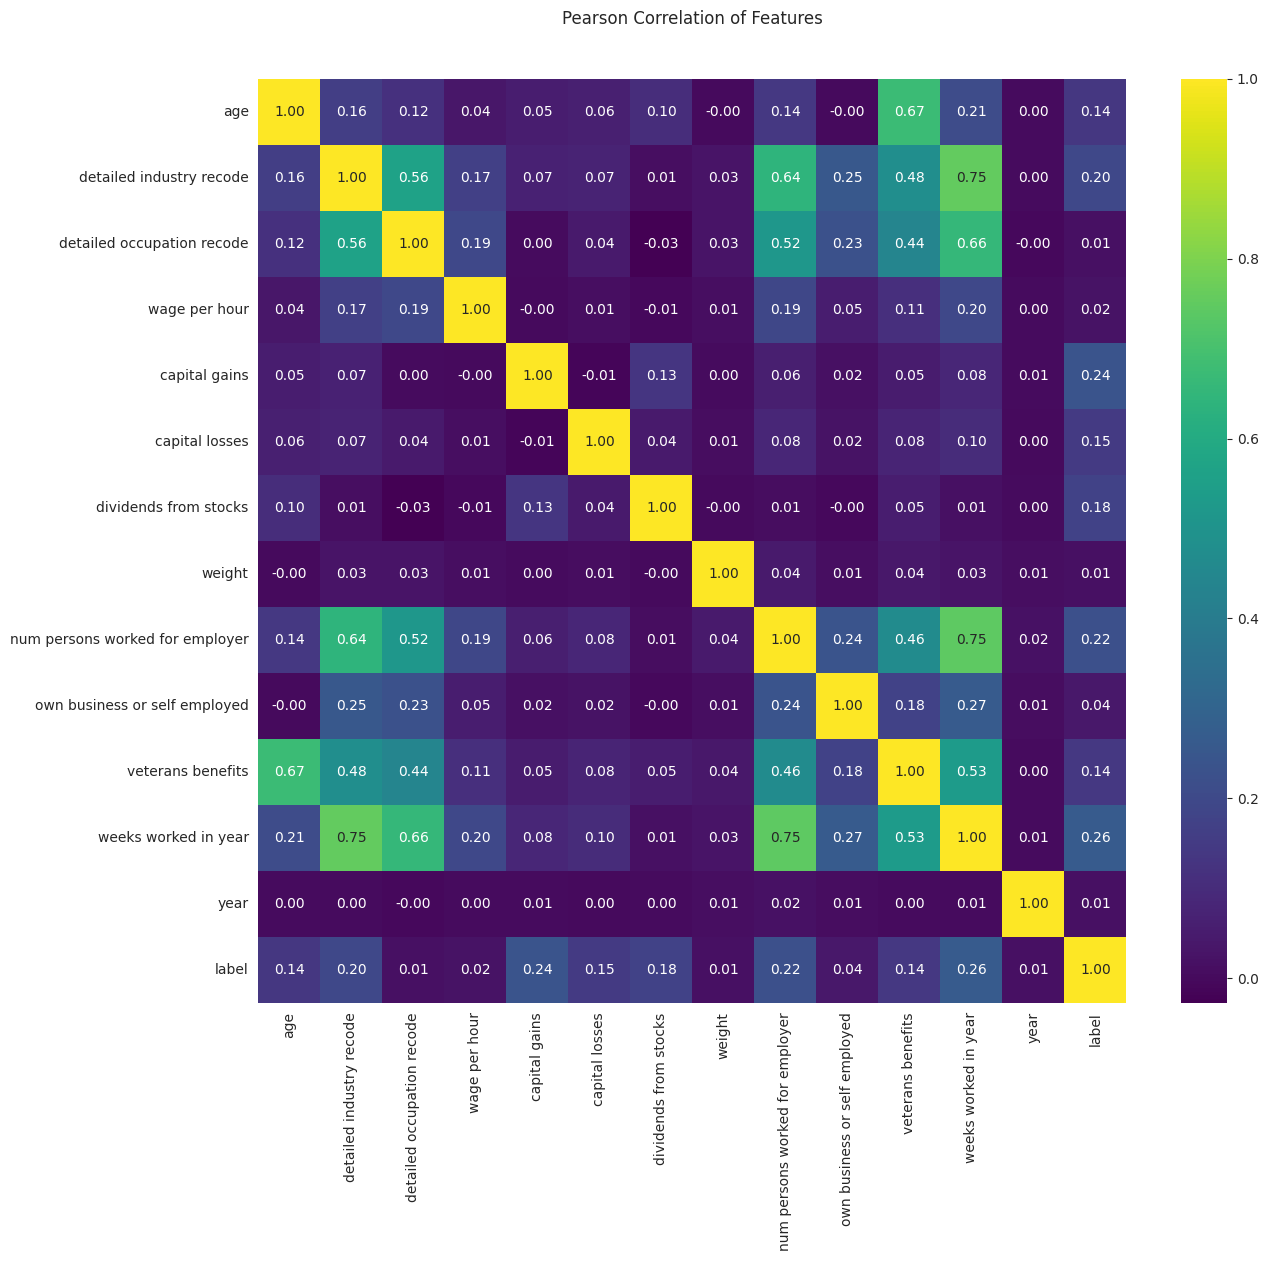

In [ ]:
# Add the encoded label to a temporary copy of the numerical dataframe
df_corr = df[numerical_vars].copy()
df_corr['label'] = y_encoded.copy()

# Generate a correlation metrics
colormap = plt.cm.viridis
plt.figure(figsize=(14, 12))
sns.heatmap(df_corr.corr(), annot=True, cmap=colormap, fmt=".2f")
plt.title('Pearson Correlation of Features', y=1.05)
plt.show()

*   The correlation metrix shows that **'weeks worked in year'** is highly correlated with **'detailed industry recode'** ($0.75$) and **'num persons worked for employer'** ($0.75$). This suggests these variables capture very similar information about employment intensity.

*   Additionally, the correlation between **'year'** and the **'label'** (or any other feature) is nearly $0.00$. Since it only indicates whether the data was collected in 1994 or 1995, it does not appear to provide predictive power for income.

In [ ]:
# Remove weeks worked in year and year from features
X = X.drop(['weeks worked in year', 'year'], axis=1)
print(f"Feature matrix shape: {X.shape}")

Feature matrix shape: (199523, 38)


In [ ]:
X_numerical_vars = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
X_categorical_vars = X.select_dtypes(include=['object']).columns.tolist()

print("Numerical Variables:", len(X_numerical_vars))
print(X_numerical_vars)
print("\nCategorical Variables:", len(X_categorical_vars))
print(X_categorical_vars)

Numerical Variables: 10
['age', 'detailed industry recode', 'detailed occupation recode', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'num persons worked for employer', 'own business or self employed', 'veterans benefits']

Categorical Variables: 28
['class of worker', 'education', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', "fill inc question

Both **'weeks worked in year'** and **'year'** features are dropped to reduce noise and the risk of overfitting the classification model.

In [ ]:
# Get categorical columns that are in X (excluding the dropped features)
categorical_vars_to_encode = [col for col in categorical_vars if col in X.columns]

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=categorical_vars_to_encode, drop_first=True, dtype=int)
print(f"\nFeature matrix after encoding: {X_encoded.shape}")
print(f"Features: {X_encoded.columns.tolist()}")


Feature matrix after encoding: (199523, 377)
Features: ['age', 'detailed industry recode', 'detailed occupation recode', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'num persons worked for employer', 'own business or self employed', 'veterans benefits', 'class of worker_Local government', 'class of worker_Never worked', 'class of worker_Not in universe', 'class of worker_Private', 'class of worker_Self-employed-incorporated', 'class of worker_Self-employed-not incorporated', 'class of worker_State government', 'class of worker_Without pay', 'education_11th grade', 'education_12th grade no diploma', 'education_1st 2nd 3rd or 4th grade', 'education_5th or 6th grade', 'education_7th and 8th grade', 'education_9th grade', 'education_Associates degree-academic program', 'education_Associates degree-occup /vocational', 'education_Bachelors degree(BA AB BS)', 'education_Children', 'education_Doctorate degree(PhD EdD)', 'education_High school graduate', 'educa

After one-hot encoding the features:
*   The **"?"** placeholder was dropped to avoid multicollinearity.
*   The **'Not in universe'** placeholder was not dropped, but kept as its own feature. It is possible that this is not missing data; rather, the question was not applicable to that individual. We can validate this using a data dictionary if provided by the retail business client.

In [ ]:
# Handle any remaining missing values by filling with median for numeric
X_encoded = X_encoded.fillna(X_encoded.median())

print(f"Missing values after preprocessing: {X_encoded.isnull().sum().sum()}")
print(f"Final feature matrix shape: {X_encoded.shape}")

Missing values after preprocessing: 0
Final feature matrix shape: (199523, 377)


*   Missing values were handled in the **'hispanic origin'** variable by replacing them with median values, because it is not influenced by those extreme outliers.
*   After one-hot encoding, our feature matrix **X_encoded** dimension is (199523, 377). We will use this to develop our classification model.



## **STEP3 - Model Development**

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining set class proportions:\n{pd.Series(y_train).value_counts(normalize=True)}")
print(f"\nTest set class proportions:\n{pd.Series(y_test).value_counts(normalize=True)}")

Training set size: (159618, 377)
Test set size: (39905, 377)

Training set class proportions:
0    0.937939
1    0.062061
Name: proportion, dtype: float64

Test set class proportions:
0    0.937953
1    0.062047
Name: proportion, dtype: float64


To ensure the training and test sets preserve the same proportion of high-income and low-income classes as the original dataset, we used startified sampling technique during data split.

In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeatures scaled - mean: {X_train_scaled.mean():.4f}, std: {X_train_scaled.std():.4f}")


Features scaled - mean: -0.0000, std: 1.0000


Since our dataset contains variables with different scales, standardization is used to transforms all features to have a mean of 0 and a standard deviation of 1, ensuring they are all treated equally by machine learning algorithms.

In [ ]:
# Define Models
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'Gaussian Naive Bayes': GaussianNB(),
    'SVM': SGDClassifier(loss='modified_huber', random_state=42)
    #'SVM': SVC(probability=True, random_state=42) # Require more computational cost and training time

}


To find the best balance for predicting income levels, our candidate models include both classical (Logistic Regression, Gaussian Naive Bayes, SVM, RF) and state-of-the-art algorithms (GBM, XGBoost) for tabular data.



## Train Classification Models on Training Set

In [ ]:
# Train models
train_results = {}
train_predictions = {}

for name, clf in classifiers.items():
    # Choose appropriate feature set
    if name == 'Gaussian Naive Bayes':
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_train)
        y_prob = clf.predict_proba(X_train)[:, 1]
    else:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_train_scaled)
        y_prob = clf.predict_proba(X_train_scaled)[:, 1]

    # Calculate metrics on Training Set
    accuracy = accuracy_score(y_train, y_pred)
    precision = classification_report(y_train, y_pred, output_dict=True)['weighted avg']['precision']
    recall = classification_report(y_train, y_pred, output_dict=True)['weighted avg']['recall']
    f1 = f1_score(y_train, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_train, y_prob)

    train_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

    train_predictions[name] = {
        'y_pred': y_pred,
        'y_prob': y_prob,
        'model': clf
    }

    print(f"\n{name} Results:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")


Logistic Regression Results:
  Accuracy:  0.9522
  Precision: 0.9452
  Recall:    0.9522
  F1-Score:  0.9453
  ROC-AUC:   0.9429

Random Forest Results:
  Accuracy:  0.9995
  Precision: 0.9995
  Recall:    0.9995
  F1-Score:  0.9995
  ROC-AUC:   0.9999

Gradient Boosting Results:
  Accuracy:  0.9551
  Precision: 0.9492
  Recall:    0.9551
  F1-Score:  0.9488
  ROC-AUC:   0.9463

XGBoost Results:
  Accuracy:  0.9623
  Precision: 0.9587
  Recall:    0.9623
  F1-Score:  0.9584
  ROC-AUC:   0.9670

Gaussian Naive Bayes Results:
  Accuracy:  0.7033
  Precision: 0.9429
  Recall:    0.7033
  F1-Score:  0.7801
  ROC-AUC:   0.9125

SVM Results:
  Accuracy:  0.9512
  Precision: 0.9440
  Recall:    0.9512
  F1-Score:  0.9452
  ROC-AUC:   0.9028


This training set results show that the models are overfitting training set. The performance metrics are high across all algorithms, with Random Forest specifically achieving near-perfect scores of 99%. This pattern suggests that the models have memorized the training data rather than learning meaningful patterns that will transfer to new observations.

## Evaluation Classification Models on Test Set

In [ ]:
# Evaluate models
test_results = {}
test_predictions = {}

for name, clf in classifiers.items():
    # Choose appropriate feature set
    if name == 'Gaussian Naive Bayes':
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]
    else:
        y_pred = clf.predict(X_test_scaled)
        y_prob = clf.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics on Test Set
    accuracy = accuracy_score(y_test, y_pred)
    precision = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['precision']
    recall = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['recall']
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_prob)

    test_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

    test_predictions[name] = {
        'y_pred': y_pred,
        'y_prob': y_prob,
        'model': clf
    }

    print(f"\n{name} Results:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")


Logistic Regression Results:
  Accuracy:  0.9522
  Precision: 0.9451
  Recall:    0.9522
  F1-Score:  0.9448
  ROC-AUC:   0.9420

Random Forest Results:
  Accuracy:  0.9537
  Precision: 0.9472
  Recall:    0.9537
  F1-Score:  0.9468
  ROC-AUC:   0.9384

Gradient Boosting Results:
  Accuracy:  0.9551
  Precision: 0.9493
  Recall:    0.9551
  F1-Score:  0.9486
  ROC-AUC:   0.9475

XGBoost Results:
  Accuracy:  0.9571
  Precision: 0.9520
  Recall:    0.9571
  F1-Score:  0.9523
  ROC-AUC:   0.9530

Gaussian Naive Bayes Results:
  Accuracy:  0.7078
  Precision: 0.9434
  Recall:    0.7078
  F1-Score:  0.7834
  ROC-AUC:   0.9136

SVM Results:
  Accuracy:  0.9514
  Precision: 0.9442
  Recall:    0.9514
  F1-Score:  0.9450
  ROC-AUC:   0.9028


* The test set results show that XGBoost achieved the best overall performance across all metrics on the test set with an accuracy of 95.71% and a ROC-AUC of 0.9530. This suggests that the model is either very good or overfitting the dataset.

## Select Best Classification Model

In [ ]:
# Select best model
results_df = pd.DataFrame(test_results).T
best_model_name = results_df['ROC-AUC'].idxmax()
best_model_results = test_predictions[best_model_name]
y_pred_best = best_model_results['y_pred']
y_prob_best = best_model_results['y_prob']

print(f"Best Model: {best_model_name}")
print(f"ROC-AUC Score: {results_df.loc[best_model_name, 'ROC-AUC']:.4f}")

# Detailed classification report
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_best, target_names=['<$50k', '>$50k']))

Best Model: XGBoost
ROC-AUC Score: 0.9530

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

       <$50k       0.97      0.99      0.98     37429
       >$50k       0.75      0.46      0.57      2476

    accuracy                           0.96     39905
   macro avg       0.86      0.73      0.77     39905
weighted avg       0.95      0.96      0.95     39905



* The model is good at predicting <$50k dollars income class, correctly identifying 99% (high recall) of people who earn less than 50k dollars at 97% precision.

* However, the model is conservative in predicting >$50k dollars income class. It misses 54% of people who actually earn more that 50k dollars (low recall). Though when it does predict this class, it's fairly reliable at 75% precision.

> Question 2: Is maximize the number of high-income earners reached important for marketing purposes?



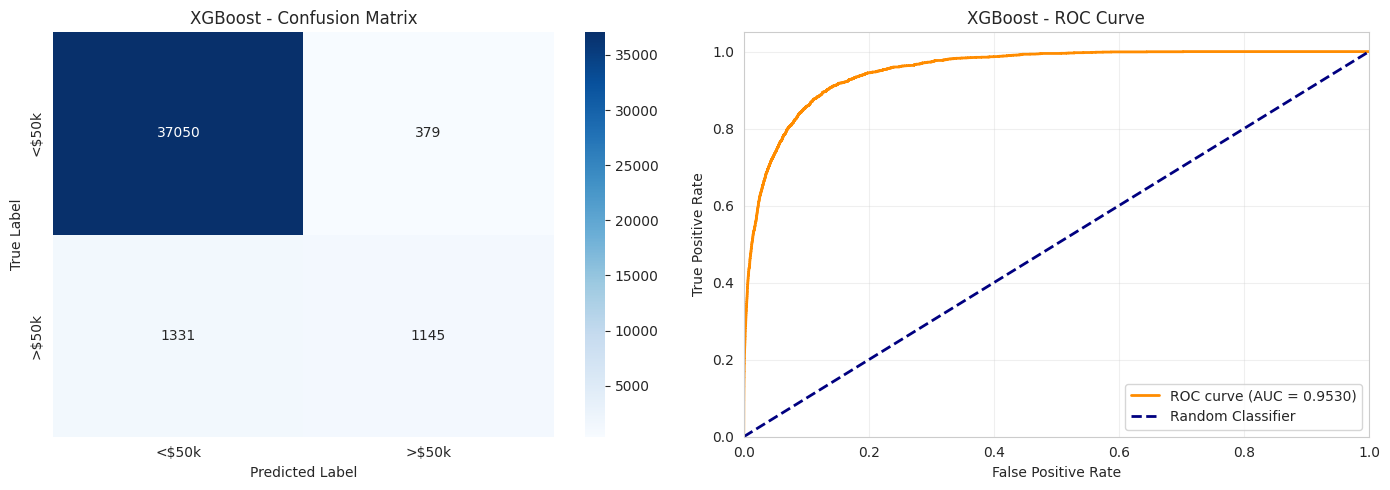

In [ ]:
# Visualize confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
conf_matrix = confusion_matrix(y_test, y_pred_best)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['<$50k', '>$50k'], yticklabels=['<$50k', '>$50k'])
axes[0].set_title(f'{best_model_name} - Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title(f'{best_model_name} - ROC Curve')
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

* With 379 False Positives and 1331 Fale Negatives, the model is good at predicting <$50k income class, but misses quite a number of high earners. This might be because of the majority class in the dataset consist of people who earn less that 50k dollars.

* The high ROC-AUC (0.95) suggests the model has good separation between the two classes. That is, at 95% of the time, a randomly selected high earner will have a higher probability score than a randomly selected low earner.

## Improvement Opportunities

* To be certain the XGBoost is not overfitting the dataset, we could explore better evealuation methods using cross-validation and other algorithms like neural networks (FT-Transformer).

* We could also address class imbalance by oversampling the minority class using techniques like SMOTE.

* In addition, we can spend time tweaking hyperparameters like probability threshold to determine a custom value that balances the cost of a "False Positive" (wasted marketing) versus a "False Negative" (missed customer).

* Furthermore, while weights column was not used as a predictive features, they can be used during the future training process, like using the sample_weight parameter in XGBoost, to ensure the model reflects the actual population distribution of the 1994-1995 Census.






